In [12]:
%matplotlib widget
import numpy as np
from astropy import units as u, constants as c
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import matplotlib
from astropy.convolution import convolve, Gaussian2DKernel
from scipy.optimize import fsolve, fmin
from astropy.io import fits
import scipy.interpolate as interp

In [13]:
cnfw = 7 # NFW concentration parameter
z = 2.3 # redshift
Rs = 27 # kpc = Rvir = 90 kpc
H = cosmo.H(z).to('km/s/kpc').value
# print(H)
# M_h = 1e12*u.M_sun
# rho0 = 3*M_h/(4*np.pi*Rs**3) * 0.5
# A = 8*np.pi*c.G*rho0*Rs**3/(1*u.kpc)
A = 1.2e7 #* u.km**2/u.s**2

bres = 2 # kpc
min_b = 10 # kpc
max_b = 250 # kpc
bvec = np.arange(min_b, max_b, bres)
vrawsamp = np.arange(-1000, 1000, 30)

bvec_final = np.arange(min_b, max_b+2.5, 5)
vvec_final = np.arange(-1000, 1050, 100)

/tmp/ipykernel_3425492/4263216231.py:6: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))


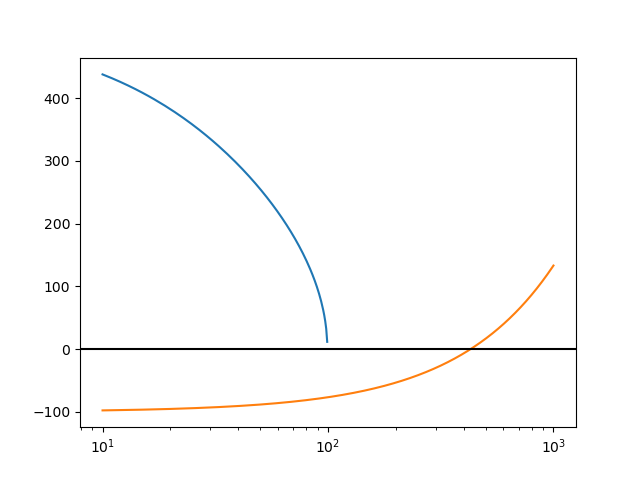

In [16]:
    
def vins(r):
    vin = voff + H*r
    return vin

def vouts(r):
    vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
    return vout

def vouts_new(r):
    x = r/Rs
    vout_sq = 1/x * (np.log(1+cnfw*x) - (cnfw*x)/(1+cnfw*x))/(np.log(1+cnfw) - cnfw/(1+cnfw))
    vout = 600 * np.sqrt(vout_sq)
    return vout

vi, voff = 500, -100


rrange = np.linspace(10,1000, 1000)
plt.figure()
plt.semilogx(rrange, vouts(rrange))
# plt.semilogx(rrange, vouts_new(rrange))
plt.semilogx(rrange, vins(rrange))
# plt.semilogx(rrange, vins(rrange) + np.nan_to_num(vouts(rrange)))
plt.axhline(0, c='k')
plt.show()

In [6]:
def heatmap(vi, voff, a0out, a0in, gout, gin):
    
    def vins(r):
        vin = voff + H*r
        return vin

    def vouts(r):
        vout1 = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
        vout = vins(r) + np.nan_to_num(vout1)
        return vout

    # print(fsolve(vouts_root, 100))
    # rmaxrange_out = np.logspace(0,6,2000)
    # rmax_out = rmaxrange_out[np.nanargmin(vouts(rmaxrange_out))] #300 kpc
    
    rmax_out = 1500 #fmin(vouts, 35, ftol=0.5, disp=False)[0]
    print(rmax_out)

    # rmaxrange_in = np.logspace(0,6,2000)
    # rmax_in = rmaxrange_in[np.nanargmin(np.abs(vins(rmaxrange_in)))]
    # rmax_in = 1200*u.kpc #rmaxrange_in[np.nanargmax(vels(rmaxrange_in*u.kpc)[1])] * u.kpc #300 kpc
    rmax_in = fsolve(vins, 100)[0] #xtol = 1
    print(rmax_in)

    def ains(r):
        ain = (a0in * (r/100)**(-gin))
        return ain

    def aouts(r):
        if r > rmax_out:
            aout=0
        else:
            aout = (a0out * (r/100)**(-gout))
        return aout


    # rrange = np.linspace(10,1000, 1000)
    # plt.figure()
    # plt.semilogx(rrange, vouts(rrange))
    # plt.semilogx(rrange, vins(rrange))
    # plt.semilogx(rrange, vins(rrange) + np.nan_to_num(vouts(rrange)))
    # plt.axhline(0, c='k')
    # plt.show()
    
    taulist_out = []
    taulist_in = []


    for bi, b in enumerate(bvec):
        # print(b)
        # if b >= rmax_out-20:
        #     print(f'{b} going here')
        #     for vv in range(-vi,vi):
        #         taulist_out.append([b,vv, 0])
        #     continue
        
    
        lmax_out = np.sqrt(rmax_out**2 - b**2)
        lmax_in = np.sqrt(rmax_in**2 - b**2)
    
        larr_slowl_out = np.linspace(-lmax_out, -100, 100)
        nfast_out = int(150 * np.exp(-b/100)) #1500
        larr_fast_out = np.linspace(-100, 100, nfast_out)
        larr_slowr_out = np.linspace(100, lmax_out, 100)
        larr_out = np.concatenate([larr_slowl_out, larr_fast_out, larr_slowr_out])
    
        tau_outs = [aouts(np.sqrt(b**2 + li**2)) for li in larr_out]


        larr_slowl_in = np.linspace(-lmax_in, -100, 100)
        nfast_in = int(100 * np.exp(-b/100)) #1500
        larr_fast_in = np.linspace(-100, 100, nfast_in)
        larr_slowr_in = np.linspace(100, lmax_in, 100)
        larr_in = np.concatenate([larr_slowl_in, larr_fast_in, larr_slowr_in])
        tau_ins = [ains(np.sqrt(b**2 + li**2)) for li in larr_in]
        # print(tau_ins)

    
        r_out = np.sqrt(larr_out**2 + b**2)
        r_in = np.sqrt(larr_in**2 + b**2)
        # vout, vin = vels(r*u.kpc)

        vLOS_out = larr_out/r_out*vouts(r_out)
        vLOS_in = larr_in/r_in*vins(r_in)
        # plt.figure()
        # sc = plt.scatter(larr_out, vLOS_out, c=tau_outs)
        # plt.plot(larr_out, np.gradient(vLOS_out))
        # # sc1 = plt.scatter(larr_in, vLOS_in, c=tau_ins, cmap='inferno')
        # plt.xlabel('$\\ell$ (kpc)')
        # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
        # plt.colorbar(sc, label = '$\\tau_\\mathrm{out}$')
        # # plt.colorbar(sc1, label = '$\\tau_\\mathrm{in}$')
        # plt.title(f'$b={b}$ kpc')
        # plt.axhline(0, c = 'k', alpha = 0.7, lw = 0.7, ls = '--')
        # plt.axvline(0, c = 'k', alpha = 0.7, lw = 0.7, ls = '--')
        # plt.tight_layout()
        # plt.show()

        grad = np.gradient(vLOS_out)
        if np.min(grad) > 0:
            # print('   Smooth')
            # smooth function
            if ~np.isfinite(maxvout):
                # print(f'bad {b}')
                for j in vrawsamp:
                    taulist_out.append([b, j, 0])
            else:
                for i in range(int(np.floor(-maxvout)), int(np.ceil(maxvout)), 30): # 10 km/s
                    
                    possible_values = larr_out[(vLOS_out > i) & (vLOS_out < i+30)]
                    # print(possible_values)
                    tau_inds = [np.argwhere(larr_out == ln)[0][0] for ln in possible_values]
                    tau_out = np.array(tau_outs)[tau_inds]
                    # print(l_edge, l_mid, l_in)
                    tau_tot = np.nanmean(tau_out)
                    # print(tau_tot)
                    if np.isfinite(tau_tot):
                        taulist_out.append([b, i+15, tau_tot])
        else:
            # print('   Not Smooth')
            left_min = larr_out[np.argmin(grad[larr_out < 0])]
            right_min = np.abs(left_min)
            # print(left_min, right_min)
            
            
            minvout = np.min(vLOS_out[(larr_out > left_min) & (larr_out < 0)])
            l_minvout = larr_out[vLOS_out == minvout][0]
            l_maxvout = np.abs(l_minvout)
            # print(l_minvout, l_maxvout)
            
            maxvout = np.nanmax(vLOS_out)
            if ~np.isfinite(maxvout):
                # print(f'bad {b}')
                for j in vrawsamp:
                    taulist_out.append([b, j, 0])
            else:
                # outflow
                for i in range(int(np.floor(-maxvout)), int(np.ceil(maxvout)), 30): # 10 km/s
                
                    possible_values = larr_out[(vLOS_out > i) & (vLOS_out < i+30)]
                    
                    # print(possible_values)
                    l_edge = possible_values[(possible_values < left_min) | (possible_values > right_min)]
    
                    tau_edge_inds = [np.argwhere(larr_out == ln)[0][0] for ln in l_edge]
                    tau_out_edge = np.array(tau_outs)[tau_edge_inds]
                    
                    l_mid = possible_values[((possible_values > left_min) & (possible_values < l_minvout)) | ((possible_values < right_min) & (possible_values > l_maxvout))]
                    tau_mid_inds = [np.argwhere(larr_out == ln)[0][0] for ln in l_mid]
                    tau_out_mid = np.array(tau_outs)[tau_mid_inds]
                    
                    l_in = possible_values[(possible_values > l_minvout) & (possible_values < l_maxvout)]
                    tau_in_inds = [np.argwhere(larr_out == ln)[0][0] for ln in l_in]
                    tau_out_in = np.array(tau_outs)[tau_in_inds]
                    # print(l_edge, l_mid, l_in)
            
                    tau_tot = np.nan_to_num(np.nanmean(tau_out_edge)) + np.nan_to_num(np.nanmean(tau_out_mid)) + np.nan_to_num(np.nanmean(tau_out_in)) 
                    # print(tau_tot)
                    if np.isfinite(tau_tot):
                        taulist_out.append([b, i+15, tau_tot])
    



    tauarr_out = np.array(taulist_out)
    # print(tauarr_out)
    
    rawhmap = np.zeros((len(vrawsamp), len(bvec)))

    # if len(tauarr_in) == 0:
    #     rawhmap[:,:] = 0
    # else:

    for bi, b in enumerate(bvec):
        bcut_out = (tauarr_out[:,0] == b)
        # bcut_in = (tauarr_in[:,0] == b)
        # if len(tauarr_out[bcut_out]) == 0:
        #     tout = vrawsamp*0.0
        # else:
        tout = np.interp(vrawsamp, tauarr_out[:,1][bcut_out], tauarr_out[:,2][bcut_out], left=0, right=0)

        # if len(tauarr_in[bcut_in]) == 0:
        #     tin = vrawsamp*0.0
        # else:
        #     tin = np.interp(vrawsamp, tauarr_in[:,1][bcut_in], tauarr_in[:,2][bcut_in], left=0, right=0)

        rawhmap[:,bi] = tout # + tin

    
    # print(tauarr_out[np.isfinite(tauarr_out[:,2])])
    # plt.figure()
    # plt.scatter(tauarr_out[:,1], tauarr_out[:,2])
    # plt.plot(vrawsamp, tout)
    # plt.plot(vrawsamp, tin)
    # plt.show()
    
    plt.figure()
    sc = plt.scatter(tauarr_out[:,0], tauarr_out[:,1], c=tauarr_out[:,2]) #/cmap='inferno_r' vmin=2e-2, vmax = 1e-1 norm=matplotlib.colors.LogNorm()
    plt.colorbar(sc, label = '$\\tau_\\mathrm{out}$')
    
    # tin = plt.scatter(tauarr_in[:,0], tauarr_in[:,1], c=tauarr_in[:,2], cmap='plasma_r') #/cmap='inferno_r' vmin=2e-2, vmax = 1e-1 norm=matplotlib.colors.LogNorm()
    # plt.colorbar(tin, label = '$\\tau_\\mathrm{in}$')
    plt.xlabel('b (kpc)')
    plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
    plt.tight_layout()
    plt.show()
    
    # make map
    
    # vres = 10 #50
    # vlosr = np.arange(-1000, 1000, vres)
    
    # hmap = np.zeros((len(vlosr), len(bvec)))
    
    # for bi, b in enumerate(bvec):
    #     bcut_out = (tauarr_out[:,0] == b)
    #     bcut_in = (tauarr_in[:,0] == b)
    
    #     for vind, v in enumerate(vlosr):
    #         vcut_out = (tauarr_out[:,1] > v) & (tauarr_out[:,1] < v+vres)
    #         vcut_in = (tauarr_in[:,1] > v) & (tauarr_in[:,1] < v+vres)
            
    #         tauavg_out = np.nanmean(tauarr_out[:,2][bcut_out & vcut_out])
    #         if ~np.isfinite(tauavg_out):
    #             tauavg_out = 0
    
    #         tauavg_in = np.nanmean(tauarr_in[:,2][bcut_in & vcut_in])
    #         if ~np.isfinite(tauavg_in):
    #             tauavg_in = 0

    #         hmap[vind,bi] = tauavg_out + tauavg_in

    hmap_conv = convolve(rawhmap, Gaussian2DKernel(2,1), boundary = 'extend') # 100 km/s and 5 kpc sampling

    f = interp.RectBivariateSpline(vrawsamp, bvec, hmap_conv, kx=3, ky=3)
    hmap_reshaped = f(vvec_final, bvec_final)
    
    # print(new_im.shape)
    
    # plt.figure()
    # plt.imshow(hmap_reshaped, aspect='auto', origin='lower', extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()])
    # plt.show()
    
    # # print(hmap.shape)
    plt.figure()
    us = plt.imshow(rawhmap, origin='lower', extent = (bvec[0], bvec[-1], vrawsamp[0], vrawsamp[-1]), 
               aspect='auto', cmap='plasma')
    plt.colorbar(us, label = '$\\tau_\\mathrm{tot}$')
    plt.xlabel('b (kpc)')
    plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
    plt.title('Unsmoothed')
    # plt.xscale('log')
    plt.show()
    
    # plt.figure()
    # sm = plt.imshow(convolve(rawhmap, Gaussian2DKernel(2,4), boundary = 'extend'), origin='lower', extent = (bvec[0], bvec[-1], vrawsamp[0], vrawsamp[-1]), 
    #            aspect='auto', cmap='inferno')
    # plt.colorbar(sm, label = '$\\tau_\\mathrm{tot}$')
    # plt.xlabel('b (kpc)')
    # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
    # plt.title('Smoothed')
    # # plt.xscale('log')
    # plt.show()

    return hmap_reshaped
    


In [7]:
lya_real = fits.open('lya_conv_240618.fits')[0].data
# binterp_vec = np.arange(10,252.5,5)
# vinterp_vec = np.arange(-1000, 1050, 100)

1500
-428.85298140582347


/tmp/ipykernel_3425492/566500653.py:8: RuntimeWarning: invalid value encountered in sqrt
  vout1 = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_3425492/566500653.py:157: RuntimeWarning: Mean of empty slice
  tau_tot = np.nan_to_num(np.nanmean(tau_out_edge)) + np.nan_to_num(np.nanmean(tau_out_mid)) + np.nan_to_num(np.nanmean(tau_out_in))


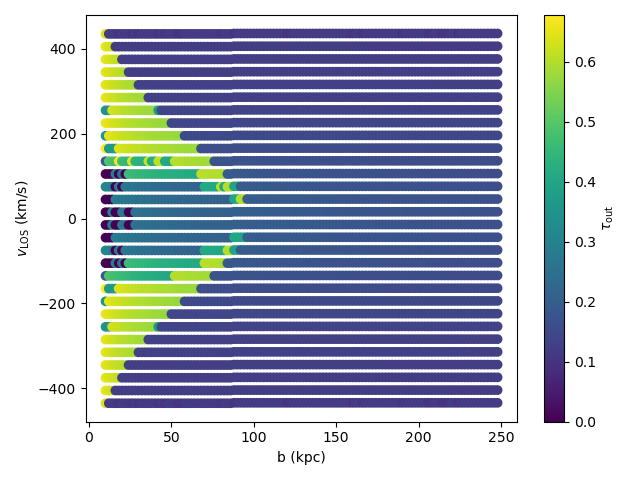

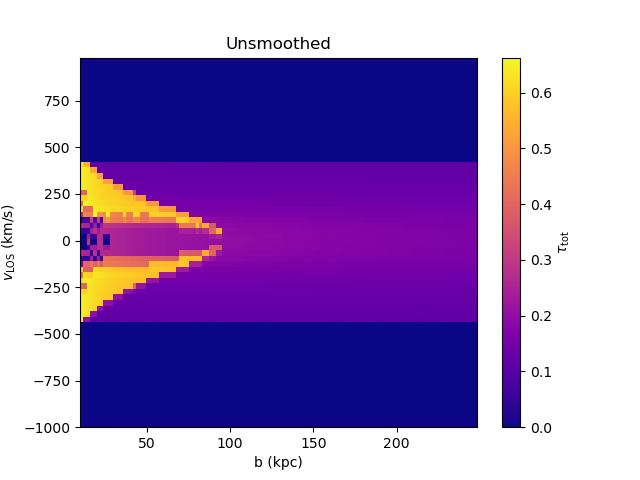

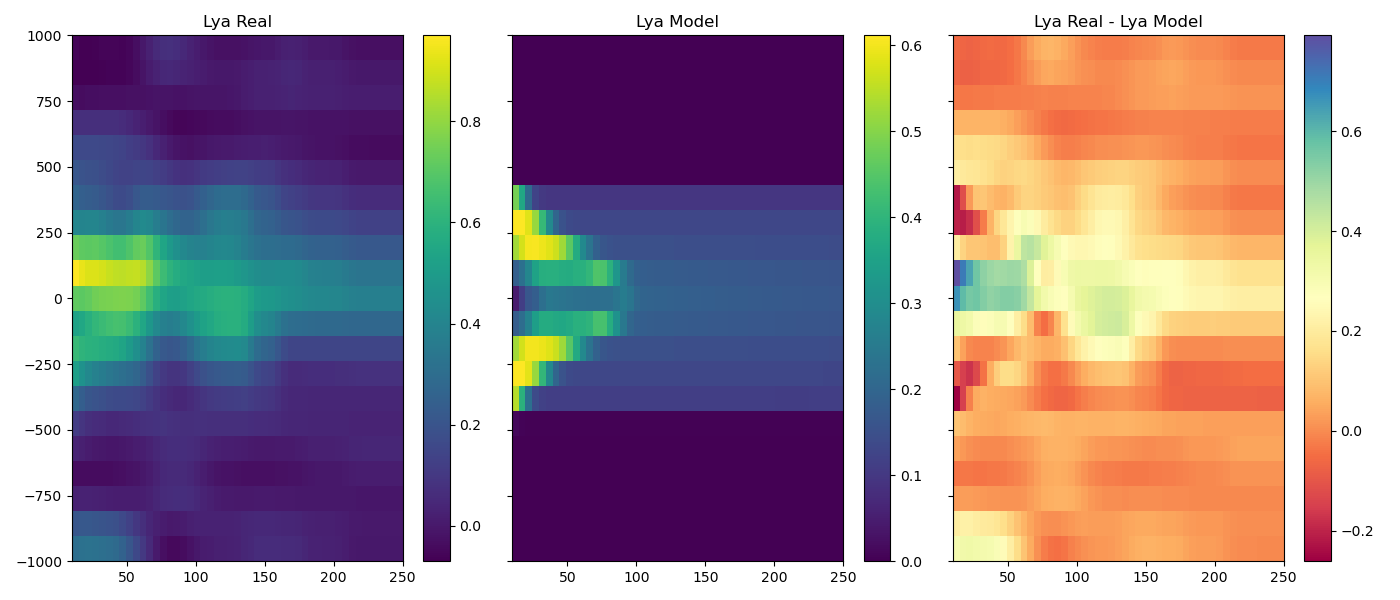

In [11]:
lya_model = heatmap(500, 100, 0.2, 0, 0.2, 0.21) #vout, vin, aout, ain, gout, gin

vmi, vma = -0.07, 0.97

fig, ax = plt.subplots(1,3, figsize = (14,6), sharex=True, sharey=True)
re = ax[0].imshow(lya_real, aspect='auto', origin='lower', 
                  extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(re, ax=ax[0])
ax[0].set_title('Lya Real')

mod = ax[1].imshow(lya_model, aspect='auto', origin='lower', 
                   extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()]) #, vmin = vmi, vmax = vma)
fig.colorbar(mod, ax=ax[1])
ax[1].set_title('Lya Model')

diff = ax[2].imshow(lya_real - lya_model, aspect='auto', origin='lower',
                    extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], cmap='Spectral')
fig.colorbar(diff, ax=ax[2])
ax[2].set_title('Lya Real - Lya Model')
fig.tight_layout()
plt.show()